# Model Halves-PMA -- Conditional Trials

In [1]:
from glob import glob
from scipy import stats
from math import sqrt
import nibabel as nb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="white")

#removed WMAZE_007 due to lack of 2nd level late_nonlearn
sids = ['WMAZE_001', 'WMAZE_002', 'WMAZE_004', 'WMAZE_005', 'WMAZE_006',
        'WMAZE_008', 'WMAZE_009', 'WMAZE_010', 'WMAZE_012',
        'WMAZE_017', 'WMAZE_018', 'WMAZE_019', 'WMAZE_020', 'WMAZE_021',
        'WMAZE_022', 'WMAZE_023', 'WMAZE_024', 'WMAZE_026', 'WMAZE_027']

##STEP 1
proj_dir = '/home/data/madlab/Mattfeld_WMAZE/' 
mask_files = []
cope_files = []
for SID in sids:
    mask_files_glob = glob(proj_dir+'/derivatives/roi_masks/hamm/anat_masks/_subject_id_' + SID + '/_anatmask_xfm*/*')
    mask_files.append(sorted(mask_files_glob))
    subjcopes_glob = glob(proj_dir+'/Hamm_Learning/HPMA/lvl2/cond/' + SID + '/fixedfx/cope_*')
    cope_files.append(sorted(subjcopes_glob))  
    if len(cope_files[-1]) == 0 or len(cope_files[-1]) != 18: 
        print(SID)

## Double-check the array indexing

In [2]:
##STEP 2a
for i, curr_mask in enumerate(mask_files[0]):
    print(i, mask_files[0][i].split('/')[-1][:-7]) #use enumerate to get index, use split to get filename 

0 lh-all_mPFC_warped
1 lh-dlPFC_warped
2 lh-dmPFC_warped
3 lh-hippocampus_warped
4 lh-mPFC_fs-3reg_warped
5 lh-mPFC_fs_warped
6 lh-mPFC_lausanne_warped
7 lh-motor_warped
8 lh-parsT_warped
9 lh_caudate_anat_mask_warped
10 lh_insula_warped
11 lh_vocc_warped
12 rh_caudate_anat_mask_warped
13 rh-all_mPFC_warped
14 rh-dlPFC_warped
15 rh-dmPFC_warped
16 rh-hippocampus_warped
17 rh-mPFC_fs-3reg_warped
18 rh-mPFC_fs_warped
19 rh-mPFC_lausanne_warped
20 rh-motor_warped
21 rh-parsT_warped
22 rh_insula_warped
23 rh_vocc_warped
24 lh-putamen_warped
25 lh_dlpfc_warped
26 lh_dlpfc_warped
27 rh-putamen_warped


In [3]:
##STEP 2b
for i, curr_cope in enumerate(cope_files[5]):
    print(i, cope_files[5][i].split('/')[-1][5:-7]) 

0 AllVsBase
1 all_remaining
2 early_learn_event
3 early_learn_pmod
4 early_nonlearn_event
5 early_nonlearn_pmod
6 event_early_learn_minus_pmod_early_learn
7 event_early_nonlearn_minus_pmod_early_nonlearn
8 event_late_learn_minus_pmod_late_learn
9 event_late_nonlearn_minus_pmod_late_nonlearn
10 late_learn_event
11 late_learn_pmod
12 late_nonlearn_event
13 late_nonlearn_pmod
14 pmod_early_learn_minus_event_early_learn
15 pmod_early_nonlearn_minus_event_early_nonlearn
16 pmod_late_learn_minus_event_late_learn
17 pmod_late_nonlearn_minus_event_late_nonlearn


### Use binarized mask to obtain activation in left & right hemisphere for each region of interest

In [4]:
##STEP 3
all_data = {'subjid':[],
            #HPC
            'lhhp_early_learn_event':[], 'rhhp_early_learn_event':[], 
            'lhhp_late_learn_event':[], 'rhhp_late_learn_event':[],
            'lhhp_early_nonlearn_event':[], 'rhhp_early_nonlearn_event':[],
            'lhhp_late_nonlearn_event':[], 'rhhp_late_nonlearn_event':[],
            'lhhp_early_learn_pmod':[], 'rhhp_early_learn_pmod':[], 
            'lhhp_late_learn_pmod':[], 'rhhp_late_learn_pmod':[],
            'lhhp_early_nonlearn_pmod':[], 'rhhp_early_nonlearn_pmod':[],
            'lhhp_late_nonlearn_pmod':[], 'rhhp_late_nonlearn_pmod':[],
            #mPFC
            'lhmpfc_early_learn_event':[], 'rhmpfc_early_learn_event':[], 
            'lhmpfc_late_learn_event':[], 'rhmpfc_late_learn_event':[],
            'lhmpfc_early_nonlearn_event':[], 'rhmpfc_early_nonlearn_event':[],
            'lhmpfc_late_nonlearn_event':[], 'rhmpfc_late_nonlearn_event':[],
            'lhmpfc_early_learn_pmod':[], 'rhmpfc_early_learn_pmod':[], 
            'lhmpfc_late_learn_pmod':[], 'rhmpfc_late_learn_pmod':[],
            'lhmpfc_early_nonlearn_pmod':[], 'rhmpfc_early_nonlearn_pmod':[],
            'lhmpfc_late_nonlearn_pmod':[], 'rhmpfc_late_nonlearn_pmod':[],
            #Caudate
            'lhcaud_early_learn_event':[], 'rhcaud_early_learn_event':[], 
            'lhcaud_late_learn_event':[], 'rhcaud_late_learn_event':[],
            'lhcaud_early_nonlearn_event':[], 'rhcaud_early_nonlearn_event':[],
            'lhcaud_late_nonlearn_event':[], 'rhcaud_late_nonlearn_event':[],
            'lhcaud_early_learn_pmod':[], 'rhcaud_early_learn_pmod':[], 
            'lhcaud_late_learn_pmod':[], 'rhcaud_late_learn_pmod':[],
            'lhcaud_early_nonlearn_pmod':[], 'rhcaud_early_nonlearn_pmod':[],
            'lhcaud_late_nonlearn_pmod':[], 'rhcaud_late_nonlearn_pmod':[],
            #Putamen
            'lhput_early_learn_event':[], 'rhput_early_learn_event':[], 
            'lhput_late_learn_event':[], 'rhput_late_learn_event':[],
            'lhput_early_nonlearn_event':[], 'rhput_early_nonlearn_event':[],
            'lhput_late_nonlearn_event':[], 'rhput_late_nonlearn_event':[],
            'lhput_early_learn_pmod':[], 'rhput_early_learn_pmod':[], 
            'lhput_late_learn_pmod':[], 'rhput_late_learn_pmod':[],
            'lhput_early_nonlearn_pmod':[], 'rhput_early_nonlearn_pmod':[],
            'lhput_late_nonlearn_pmod':[], 'rhput_late_nonlearn_pmod':[]}

##STEP 4
for i in range(len(sids)): #loop as many times as there are subects (starting at index of 1)
    all_data['subjid'].append(sids[i]) #append sid at index of current interation (i) 
    lh_hp_img = nb.load(mask_files[i][3]) #use Nibabel to load current subject's [i] regional mask file [0]
    rh_hp_img = nb.load(mask_files[i][16]) #use indices obtained in STEP 2a
    lh_mpfc_img = nb.load(mask_files[i][5])
    rh_mpfc_img = nb.load(mask_files[i][18])
    lh_caud_img = nb.load(mask_files[i][9])
    rh_caud_img = nb.load(mask_files[i][12])
    lh_put_img = nb.load(mask_files[i][24])
    rh_put_img = nb.load(mask_files[i][27])
    
    early_learn_event_img = nb.load(cope_files[i][2]) #use Nibabel to load current subject's [i] cope file [2]
    late_learn_event_img = nb.load(cope_files[i][10]) #use indices obtained in STEP 2b
    early_nonlearn_event_img = nb.load(cope_files[i][4])
    late_nonlearn_event_img = nb.load(cope_files[i][12])
    early_learn_pmod_img = nb.load(cope_files[i][3])
    late_learn_pmod_img = nb.load(cope_files[i][11])
    early_nonlearn_pmod_img = nb.load(cope_files[i][5])
    late_nonlearn_pmod_img = nb.load(cope_files[i][13])
        
    ##STEP 5
    region = ['hp', 'mpfc', 'caud', 'put']
    learn_type = ['early_learn_event', 'late_learn_event', 'early_nonlearn_event', 'late_nonlearn_event',
                  'early_learn_pmod', 'late_learn_pmod', 'early_nonlearn_pmod', 'late_nonlearn_pmod']   
    for r in region:
        for l in learn_type:
            lh_data = eval('{0}_img.get_data()[lh_{1}_img.get_data() > 0.]'.format(l,r))           
            rh_data = eval('{0}_img.get_data()[rh_{1}_img.get_data() > 0.]'.format(l,r))
            all_data['lh{0}_{1}'.format(r,l)].append(np.mean(lh_data)) 
            all_data['rh{0}_{1}'.format(r,l)].append(np.mean(rh_data))

all_data_df = pd.DataFrame(all_data)

<string>:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


### Combine the two hemispheres to create one regional average

In [5]:
##STEP 6
region = ['hp', 'mpfc', 'caud', 'put']
learn_type = ['early_learn_event', 'late_learn_event', 'early_nonlearn_event', 'late_nonlearn_event',
              'early_learn_pmod', 'late_learn_pmod', 'early_nonlearn_pmod', 'late_nonlearn_pmod']
for r in region:
    for l in learn_type:
        all_data_df['{0}_all_{1}'.format(r,l)] = (all_data_df['lh{0}_{1}'.format(r,l)] 
                                                  + all_data_df['rh{0}_{1}'.format(r,l)])/2.

## Hippocampus

In [6]:
#STEP 7
hp_chart = {}
for x in ['early_learn_event', 'late_learn_event', 'early_nonlearn_event', 'late_nonlearn_event',
          'early_learn_pmod', 'late_learn_pmod', 'early_nonlearn_pmod', 'late_nonlearn_pmod']:
    hp_chart['{0}'.format(x)] = all_data_df['hp_all_{0}'.format(x)] 
hp_chart_df = pd.DataFrame.from_dict(hp_chart)

In [7]:
#prints HPC dataframe -- displays individual subject values for each condition
hp_chart_df

,early_learn_event,late_learn_event,early_nonlearn_event,late_nonlearn_event,early_learn_pmod,late_learn_pmod,early_nonlearn_pmod,late_nonlearn_pmod
0,-9.609348,6.598615,-41.861935,-55.959166,14.178862,-10.171808,39.124533,65.726311
1,-13.597192,11.700161,10.330704,-20.163928,13.901381,11.195168,-22.466488,22.240228
2,-3.968821,88.810158,20.453554,-18.189633,6.279354,-98.565331,-25.345758,27.217735
3,2.442318,3.935853,-6.606809,2.458280,-1.724622,-7.672548,3.642636,-1.005386
4,-13.315576,-7.361041,-19.253949,36.804296,16.656442,7.481685,19.152699,-47.086900
5,-7.128073,-1.822579,-5.247334,-34.614004,6.483897,3.210135,6.712805,48.966902
6,-24.018289,-36.911438,38.610519,-30.383034,32.232780,50.109520,-60.259743,39.248931
7,-27.370386,-18.525311,-9.771428,-27.955321,57.903332,22.928897,15.999181,54.458654
8,-8.433974,-8.845978,13.675105,-22.071179,12.859416,13.785658,-46.318193,28.133536
9,-10.088588,4.308225,0.339257,5.245069,16.083119,-8.567380,-4.214539,-16.438951


Mean early_learn_event:  -12.422324695085225
STD early_learn_event:  15.394890422097417
Shapiro early_learn_event 0.0007874188013374805

Mean early_learn_pmod:  18.66399649177727
STD early_learn_pmod:  24.76338074676635
Shapiro early_learn_pmod 0.0002482616691850126

Mean late_learn_event:  -13.851225852966309
STD late_learn_event:  41.671447621079196
Shapiro late_learn_event 0.001297905226238072

Mean late_learn_pmod:  19.14758397403516
STD late_learn_pmod:  48.11027730347659
Shapiro late_learn_pmod 0.004906886722892523

Mean early_nonlearn_event:  6.4995973486649365
STD early_nonlearn_event:  24.691888662794106
Shapiro early_nonlearn_event 0.7050496935844421

Mean early_nonlearn_pmod:  -13.81825104826375
STD early_nonlearn_pmod:  34.5540281443756
Shapiro early_nonlearn_pmod 0.9688758850097656

Mean late_nonlearn_event:  -16.878696761633222
STD late_nonlearn_event:  67.1807691106273
Shapiro late_nonlearn_event 5.997265543555841e-05

Mean late_nonlearn_pmod:  22.092870909916726
STD lat

<ipython-input-8-f48b721f0f67>:42: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(hp_allsubjs[:4], whis='range', positions=ind, widths=0.15, patch_artist=True,
<ipython-input-8-f48b721f0f67>:51: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(hp_allsubjs[4:], whis='range', positions=ind, widths=0.15, patch_artist=True,


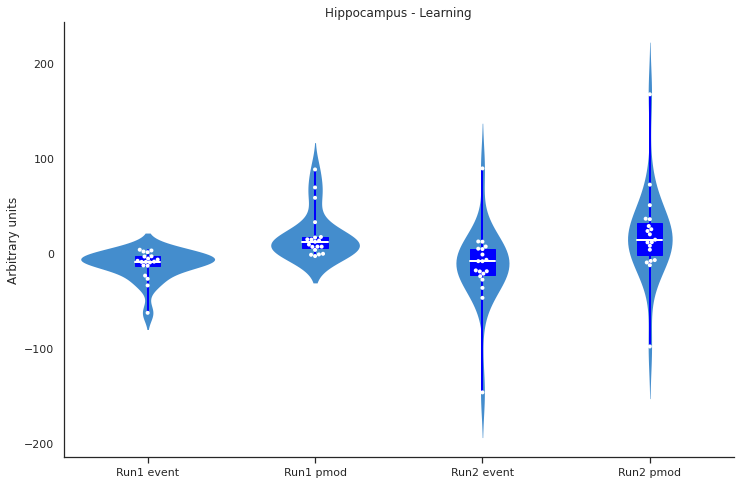

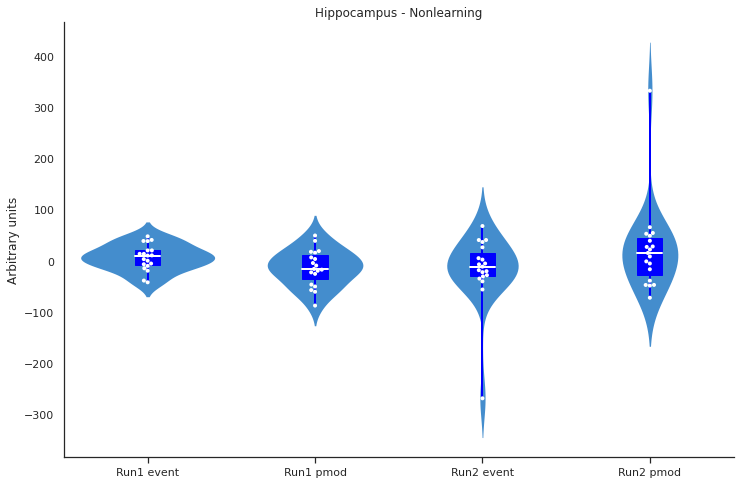

In [8]:
##STEP 8
#Iterate through all conditions to print Mean and STD for each
for d in ['early_learn_event', 'early_learn_pmod', 'late_learn_event', 'late_learn_pmod',
          'early_nonlearn_event', 'early_nonlearn_pmod', 'late_nonlearn_event', 'late_nonlearn_pmod']:
    print("Mean {0}: ".format(d), np.mean(hp_chart['{0}'.format(d)]))
    print("STD {0}: ".format(d), np.std(hp_chart['{0}'.format(d)]))
    print("Shapiro {0}".format(d), stats.shapiro(hp_chart['{0}'.format(d)])[1])
    print("")

for i in ['early_learn', 'late_learn', 'early_nonlearn', 'late_nonlearn']: 
    print("{0}: ".format(i))
    if stats.shapiro(hp_chart['{0}_event'.format(i)])[1] < 0.049 or stats.shapiro(hp_chart['{0}_pmod'.format(i)])[1] < 0.049:
        #add visual indicators if nonparametric test is significant
        if stats.wilcoxon(hp_chart['{0}_event'.format(i)], hp_chart['{0}_pmod'.format(i)])[:][-1] < 0.0124: #correction for multi comparisons
            print('Wilcoxon', stats.wilcoxon(hp_chart['{0}_event'.format(i)], hp_chart['{0}_pmod'.format(i)])[:], '<---- **')
        else:
            print('Wilcoxon', stats.wilcoxon(hp_chart['{0}_event'.format(i)], hp_chart['{0}_pmod'.format(i)])[:])
    else: #normal distributions
        if stats.ttest_rel(hp_chart['{0}_event'.format(i)], hp_chart['{0}_pmod'.format(i)])[:][-1] < 0.0124: #correction for multi comparisons
            print('t-test', stats.ttest_rel(hp_chart['{0}_event'.format(i)], hp_chart['{0}_pmod'.format(i)])[:], '<---- **')
        else:
            print('t-test', stats.ttest_rel(hp_chart['{0}_event'.format(i)], hp_chart['{0}_pmod'.format(i)])[:])   

    learning_d = ((np.average(hp_chart['{0}_event'.format(i)]) - np.average(hp_chart['{0}_pmod'.format(i)])) 
                / (sqrt((np.std(hp_chart['{0}_event'.format(i)],ddof=1))**2+np.std(hp_chart['{0}_pmod'.format(i)],ddof=1)**2)/2))
    print("Cohen's d = ", learning_d)
    print("")
    
#plot data using box and swarmplots
N = 4
conditions = ['Run1 event', 'Run1 pmod', 'Run2 event', 'Run2 pmod'] #labels
hp_allsubjs = [hp_chart['early_learn_event'], hp_chart['early_learn_pmod'],
               hp_chart['late_learn_event'], hp_chart['late_learn_pmod'], 
               hp_chart['early_nonlearn_event'], hp_chart['early_nonlearn_pmod'], 
               hp_chart['late_nonlearn_event'], hp_chart['late_nonlearn_pmod']] #data to plot
ind = np.arange(N) #number of ticks for x-axis
for i in range(2):
    fig, ax = plt.subplots(figsize = (12,8)) #general plotting parameters (size, number, etc)
    sns.despine(top=True)
    if i == 0:
        sns.violinplot(data=hp_allsubjs[:4], color="#278fea", inner=None, linewidth=0, saturation=0.7)
        ax.boxplot(hp_allsubjs[:4], whis='range', positions=ind, widths=0.15, patch_artist=True,
                   showcaps=False, boxprops=dict(color="blue", facecolor="blue"),
                   whiskerprops=dict(color="blue", linewidth=2, linestyle = "-"),
                   medianprops=dict(color="w", linewidth=2))
        sns.swarmplot(data = hp_allsubjs[:4], size = 4, color = "white", edgecolor = "gray")
        ax.set_xticklabels(conditions) #labels x-axis ticks
        ax.set_title("Hippocampus - Learning") #title to entire plot  
    else:
        sns.violinplot(data=hp_allsubjs[4:], color="#278fea", inner=None, linewidth=0, saturation=0.7)
        ax.boxplot(hp_allsubjs[4:], whis='range', positions=ind, widths=0.15, patch_artist=True,
                   showcaps=False, boxprops=dict(color="blue", facecolor="blue"),
                   whiskerprops=dict(color="blue", linewidth=2, linestyle = "-"),
                   medianprops=dict(color="w", linewidth=2))
        sns.swarmplot(data = hp_allsubjs[4:], size = 4, color = "white", edgecolor = "gray")
        ax.set_xticklabels(conditions) #labels x-axis ticks
        ax.set_title("Hippocampus - Nonlearning") #title to entire plot 
    ax.set_xticks(ind) #draws x-axis ticks
    ax.xaxis.set_ticks_position('bottom')
    ax.set_ylabel("Arbitrary units") #typical label of BOLD activation
    #plt.savefig("/home/arenf001/figs/HPMA_C_hpc{0}.png".format(i+1), dpi = 800)
plt.show() #command to draw plot (also resets if looped)

Shapiro early_event 0.4875205159187317
Shapiro late_event 0.000383961625630036
Shapiro early_pmod 0.1973901093006134
Shapiro late_pmod 0.0005642100586555898
Mean early_event:  -2.961363673210144
STD early_event:  12.85252560569289

Mean early_pmod:  2.4228727217567596
STD early_pmod:  17.923256713537885

Mean late_event:  -15.364961307299765
STD late_event:  35.77066683916357

Mean late_pmod:  20.620227441975945
STD late_pmod:  43.969322519492614

early: 
t-test (-0.7496576132172093, 0.4631470614475949)
Cohen's d =  0.4752292328746967

late: 
Wilcoxon (46.0, 0.049365997314453125)
Cohen's d =  1.235857943281044



<ipython-input-24-349254706be8>:42: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(hp_allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,


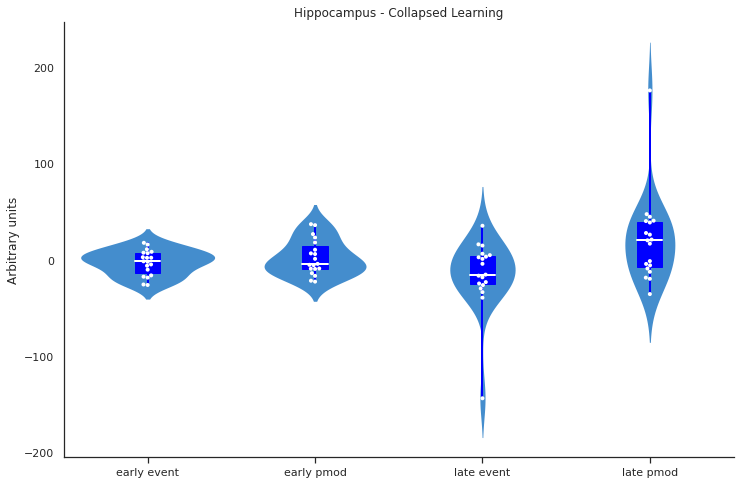

In [24]:
##STEP 9
plot = {}
plot['early_event'] = all_data_df[['hp_all_early_learn_event','hp_all_early_nonlearn_event']].mean(axis=1)
plot['late_event'] = all_data_df[['hp_all_late_learn_event','hp_all_late_nonlearn_event']].mean(axis=1)
plot['early_pmod'] = all_data_df[['hp_all_early_learn_pmod','hp_all_early_nonlearn_pmod']].mean(axis=1)
plot['late_pmod'] = all_data_df[['hp_all_late_learn_pmod','hp_all_late_nonlearn_pmod']].mean(axis=1)
plot_df = pd.DataFrame.from_dict(plot)
for key in plot_df:
    print("Shapiro {0}".format(key), stats.shapiro(plot_df['{0}'.format(key)])[1])
for d in ['early_event', 'early_pmod', 'late_event', 'late_pmod']:
    print("Mean {0}: ".format(d), np.mean(plot['{0}'.format(d)]))
    print("STD {0}: ".format(d), np.std(plot['{0}'.format(d)]))
    print("")  
    
for i in ['early', 'late']:
    print("{0}: ".format(i))
    if stats.shapiro(plot['{0}_event'.format(i)])[1] < 0.049 or stats.shapiro(plot['{0}_pmod'.format(i)])[1] < 0.024:
        #add visual indicators if nonparametric test is significant
        if stats.wilcoxon(plot['{0}_event'.format(i)], plot['{0}_pmod'.format(i)])[:][-1] < 0.024: #correction for multi comparisons
            print('Wilcoxon', stats.wilcoxon(plot['{0}_event'.format(i)], plot['{0}_pmod'.format(i)])[:], '<---- **')
        else:
            print('Wilcoxon', stats.wilcoxon(plot['{0}_event'.format(i)], plot['{0}_pmod'.format(i)])[:])
    else: #normal distributions
        if stats.ttest_rel(plot['{0}_event'.format(i)], plot['{0}_pmod'.format(i)])[:][-1] < 0.024: #correction for multi comparisons
            print('t-test', stats.ttest_rel(plot['{0}_event'.format(i)], plot['{0}_pmod'.format(i)])[:], '<---- **')
        else:
            print('t-test', stats.ttest_rel(plot['{0}_event'.format(i)], plot['{0}_pmod'.format(i)])[:])   

    learning_d = ((np.average(plot['{0}_pmod'.format(i)]) - np.average(plot['{0}_event'.format(i)])) 
                / (sqrt((np.std(plot['{0}_pmod'.format(i)],ddof=1))**2+np.std(plot['{0}_event'.format(i)],ddof=1)**2)/2))
    print("Cohen's d = ", learning_d)
    print("")

N = 4
conditions = ['early event', 'early pmod', 'late event', 'late pmod']
hp_allsubjs = [plot['early_event'], plot['early_pmod'], plot['late_event'], plot['late_pmod']]
ind = np.arange(N)
width = 0.5
fig, ax = plt.subplots(figsize = (12,8))
sns.despine(top=True)
sns.violinplot(data=hp_allsubjs, color="#278fea", inner=None, linewidth=0, saturation=0.7)
ax.boxplot(hp_allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,
           showcaps=False, boxprops=dict(color="blue", facecolor="blue"),
           whiskerprops=dict(color="blue", linewidth=2, linestyle = "-"),
           medianprops=dict(color="w", linewidth=2))
sns.swarmplot(data = hp_allsubjs, size = 4, color = "white", edgecolor = "gray")
ax.set_xticks(ind)
ax.xaxis.set_ticks_position('bottom')
ax.set_xticklabels(conditions)
ax.set_ylabel("Arbitrary units")
ax.set_title("Hippocampus - Collapsed Learning")
#plt.savefig("/home/arenf001/figs/HPMA_C_hpc.png", dpi = 800)
plt.show()

In [10]:
plot_df

,early_event,late_event,early_pmod,late_pmod
0,-25.735641,-24.680275,26.651697,27.777251
1,-1.633244,-4.231884,-4.282553,16.717698
2,8.242367,35.310262,-9.533202,-35.673798
3,-2.082245,3.197066,0.959007,-4.338967
4,-16.284763,14.721627,17.904570,-19.802608
5,-6.187704,-18.218292,6.598351,26.088519
6,7.296115,-33.647236,-14.013482,44.679225
7,-18.570907,-23.240316,36.951256,38.693776
8,2.620566,-15.458579,-16.729389,20.959597
9,-4.874666,4.776647,5.934290,-12.503165


## mPFC

In [11]:
mpfc_chart = {}
for x in ['early_learn_event', 'late_learn_event', 'early_nonlearn_event', 'late_nonlearn_event',
          'early_learn_pmod', 'late_learn_pmod', 'early_nonlearn_pmod', 'late_nonlearn_pmod']:
    mpfc_chart['{0}'.format(x)] = all_data_df['mpfc_all_{0}'.format(x)] 
mpfc_chart_df = pd.DataFrame.from_dict(mpfc_chart)

In [12]:
mpfc_chart_df

,early_learn_event,late_learn_event,early_nonlearn_event,late_nonlearn_event,early_learn_pmod,late_learn_pmod,early_nonlearn_pmod,late_nonlearn_pmod
0,-15.956375,-3.018923,-71.655724,-24.262436,25.851730,6.496611,63.710545,27.291648
1,-2.629751,148.997314,19.302313,-20.269680,0.104863,-153.632370,-43.517350,27.648594
2,-6.796595,75.656420,13.657202,31.927771,11.299395,-99.633190,-15.063154,-47.832456
3,0.672109,6.654970,-6.639297,17.087613,-1.745108,-12.312678,3.882820,-18.737432
4,-29.975825,-5.750708,-42.551414,80.816391,39.879877,-1.481691,49.009127,-103.579521
5,-8.981645,-32.767179,6.013509,-160.885979,18.428209,37.495469,-19.815777,218.546310
6,-31.646233,-88.887245,-8.652671,31.841801,39.238389,116.145908,-0.247161,-47.197096
7,-15.279483,-13.159012,-16.232738,-14.997453,33.455150,12.414749,29.910355,28.181385
8,-8.423229,-6.953753,-12.404070,9.720113,11.186690,12.772652,-0.789340,-8.782263
9,-14.375546,81.437796,-2.478698,32.239910,14.421038,-105.373482,-10.205778,-50.466494


Mean early_learn_event:  -13.291338178280153
STD early_learn_event:  15.20488620299061
Shapiro early_learn_event 0.003527059918269515

Mean early_learn_pmod:  18.130168204244814
STD early_learn_pmod:  21.692970179056744
Shapiro early_learn_pmod 0.0053449999541044235

Mean late_learn_event:  -2.6314074742166618
STD late_learn_event:  54.758205875392186
Shapiro late_learn_event 0.08164013177156448

Mean late_learn_pmod:  4.699774541352925
STD late_learn_pmod:  65.21067332328364
Shapiro late_learn_pmod 0.11455024778842926

Mean early_nonlearn_event:  3.7450015278239
STD early_nonlearn_event:  39.44805222176148
Shapiro early_nonlearn_event 0.31543517112731934

Mean early_nonlearn_pmod:  -10.808269878751354
STD early_nonlearn_pmod:  49.62904271565664
Shapiro early_nonlearn_pmod 0.18023154139518738

Mean late_nonlearn_event:  4.8123948181930345
STD late_nonlearn_event:  61.0047426948417
Shapiro late_nonlearn_event 0.2451821118593216

Mean late_nonlearn_pmod:  -3.578875845200137
STD late_nonl

<ipython-input-13-3015c5986334>:42: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(mpfc_allsubjs[:4], whis='range', positions=ind, widths=0.15, patch_artist=True,
<ipython-input-13-3015c5986334>:51: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(mpfc_allsubjs[4:], whis='range', positions=ind, widths=0.15, patch_artist=True,


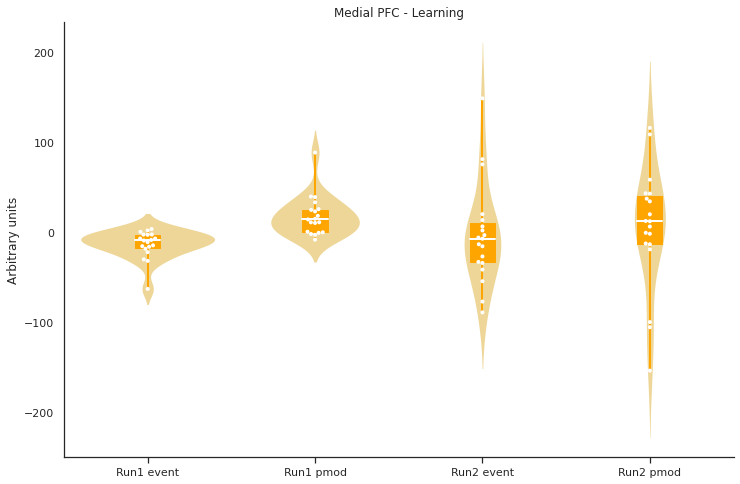

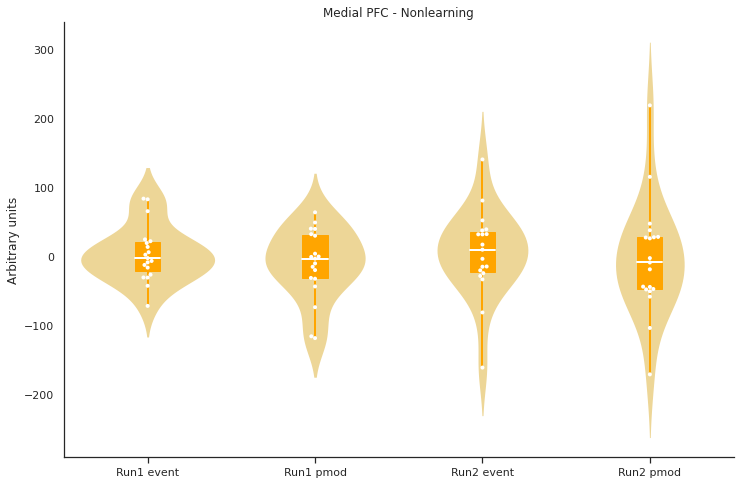

In [13]:
##STEP 8
#Iterate through all conditions to print Mean and STD for each
for d in ['early_learn_event', 'early_learn_pmod', 'late_learn_event', 'late_learn_pmod',
          'early_nonlearn_event', 'early_nonlearn_pmod', 'late_nonlearn_event', 'late_nonlearn_pmod']:
    print("Mean {0}: ".format(d), np.mean(mpfc_chart['{0}'.format(d)]))
    print("STD {0}: ".format(d), np.std(mpfc_chart['{0}'.format(d)]))
    print("Shapiro {0}".format(d), stats.shapiro(mpfc_chart['{0}'.format(d)])[1])
    print("")
    
for i in ['early_learn', 'late_learn', 'early_nonlearn', 'late_nonlearn']: 
    print("{0}: ".format(i))
    if stats.shapiro(mpfc_chart['{0}_event'.format(i)])[1] < 0.049 or stats.shapiro(mpfc_chart['{0}_pmod'.format(i)])[1] < 0.049:
        #add visual indicators if nonparametric test is significant
        if stats.wilcoxon(mpfc_chart['{0}_event'.format(i)], mpfc_chart['{0}_pmod'.format(i)])[:][-1] < 0.0124: #correction for multi comparisons
            print('Wilcoxon', stats.wilcoxon(mpfc_chart['{0}_event'.format(i)], mpfc_chart['{0}_pmod'.format(i)])[:], '<---- **')
        else:
            print('Wilcoxon', stats.wilcoxon(mpfc_chart['{0}_event'.format(i)], mpfc_chart['{0}_pmod'.format(i)])[:])
    else: #normal distributions
        if stats.ttest_rel(mpfc_chart['{0}_event'.format(i)], mpfc_chart['{0}_pmod'.format(i)])[:][-1] < 0.0124: #correction for multi comparisons
            print('t-test', stats.ttest_rel(mpfc_chart['{0}_event'.format(i)], mpfc_chart['{0}_pmod'.format(i)])[:], '<---- **')
        else:
            print('t-test', stats.ttest_rel(mpfc_chart['{0}_event'.format(i)], mpfc_chart['{0}_pmod'.format(i)])[:])   

    learning_d = ((np.average(mpfc_chart['{0}_event'.format(i)]) - np.average(mpfc_chart['{0}_pmod'.format(i)])) 
                / (sqrt((np.std(mpfc_chart['{0}_event'.format(i)],ddof=1))**2+np.std(mpfc_chart['{0}_pmod'.format(i)],ddof=1)**2)/2))
    print("Cohen's d = ", learning_d)
    print("")
    
#plot data using box and swarmplots
N = 4
conditions = ['Run1 event', 'Run1 pmod', 'Run2 event', 'Run2 pmod'] #labels
mpfc_allsubjs = [mpfc_chart['early_learn_event'], mpfc_chart['early_learn_pmod'],
                 mpfc_chart['late_learn_event'], mpfc_chart['late_learn_pmod'], 
                 mpfc_chart['early_nonlearn_event'], mpfc_chart['early_nonlearn_pmod'], 
                 mpfc_chart['late_nonlearn_event'], mpfc_chart['late_nonlearn_pmod']] #data to plot
ind = np.arange(N) #number of ticks for x-axis
for i in range(2):
    fig, ax = plt.subplots(figsize = (12,8)) #general plotting parameters (size, number, etc)
    sns.despine(top=True)
    if i == 0:
        sns.violinplot(data=mpfc_allsubjs[:4], color="#ffde85", inner=None, linewidth=0, saturation=0.7)
        ax.boxplot(mpfc_allsubjs[:4], whis='range', positions=ind, widths=0.15, patch_artist=True,
                   showcaps=False, boxprops=dict(color="orange", facecolor="orange"),
                   whiskerprops=dict(color="orange", linewidth=2, linestyle = "-"),
                   medianprops=dict(color="w", linewidth=2))
        sns.swarmplot(data = mpfc_allsubjs[:4], size = 4, color = "white", edgecolor = "gray")
        ax.set_xticklabels(conditions) #labels x-axis ticks
        ax.set_title("Medial PFC - Learning") #title to entire plot  
    else:
        sns.violinplot(data=mpfc_allsubjs[4:], color="#ffde85", inner=None, linewidth=0, saturation=0.7)
        ax.boxplot(mpfc_allsubjs[4:], whis='range', positions=ind, widths=0.15, patch_artist=True,
                   showcaps=False, boxprops=dict(color="orange", facecolor="orange"),
                   whiskerprops=dict(color="orange", linewidth=2, linestyle = "-"),
                   medianprops=dict(color="w", linewidth=2))
        sns.swarmplot(data = mpfc_allsubjs[4:], size = 4, color = "white", edgecolor = "gray")
        ax.set_xticklabels(conditions) #labels x-axis ticks
        ax.set_title("Medial PFC - Nonlearning") #title to entire plot 
    ax.set_xticks(ind) #draws x-axis ticks
    ax.xaxis.set_ticks_position('bottom')
    ax.set_ylabel("Arbitrary units") #typical label of BOLD activation
    #plt.savefig("/home/arenf001/figs/HPMA_C_mpfc{0}.png".format(i+1), dpi = 800)
plt.show() #command to draw plot (also resets if looped)

Mean early_event:  -4.773168325228126
STD early_event:  18.69014311277119
Shapiro early_event 0.8595917820930481

Mean late_event:  1.0904936719881861
STD late_event:  40.62156071153492
Shapiro late_event 0.6364050507545471

Mean early_pmod:  3.6609491627467308
STD early_pmod:  23.573297930766973
Shapiro early_pmod 0.9586101770401001

Mean late_pmod:  0.5604493480763937
STD late_pmod:  52.90000883853283
Shapiro late_pmod 0.5113653540611267

early: 
t-test (-0.8522072107834637, 0.40529568444552566)
Cohen's d =  0.545757318184548

late: 
t-test (0.024075781937446313, 0.9810570592186891)
Cohen's d =  -0.015470122696880265



<ipython-input-25-293cd8d561fd>:39: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(mpfc_allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,


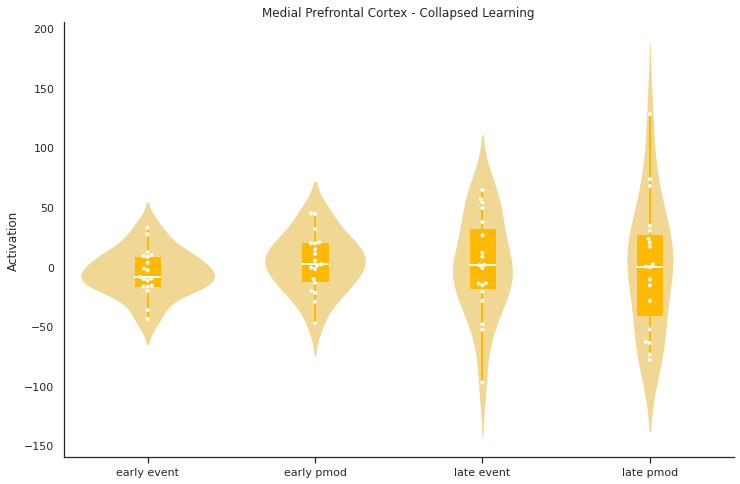

In [25]:
plot2 = {}
plot2['early_event'] = all_data_df[['mpfc_all_early_learn_event','mpfc_all_early_nonlearn_event']].mean(axis=1)
plot2['late_event'] = all_data_df[['mpfc_all_late_learn_event','mpfc_all_late_nonlearn_event']].mean(axis=1)
plot2['early_pmod'] = all_data_df[['mpfc_all_early_learn_pmod','mpfc_all_early_nonlearn_pmod']].mean(axis=1)
plot2['late_pmod'] = all_data_df[['mpfc_all_late_learn_pmod','mpfc_all_late_nonlearn_pmod']].mean(axis=1)
plot2_df = pd.DataFrame.from_dict(plot2)
for d in ['early_event', 'late_event', 'early_pmod', 'late_pmod']:
    print("Mean {0}: ".format(d), np.mean(plot2['{0}'.format(d)]))
    print("STD {0}: ".format(d), np.std(plot2['{0}'.format(d)]))
    print("Shapiro {0}".format(d), stats.shapiro(plot2['{0}'.format(d)])[1])
    print("")    
for i in ['early', 'late']:
    print("{0}: ".format(i))
    if stats.shapiro(plot2['{0}_event'.format(i)])[1] < 0.049 or stats.shapiro(plot2['{0}_pmod'.format(i)])[1] < 0.024:
        #add visual indicators if nonparametric test is significant
        if stats.wilcoxon(plot2['{0}_event'.format(i)], plot2['{0}_pmod'.format(i)])[:][-1] < 0.024: #correction for multi comparisons
            print('Wilcoxon', stats.wilcoxon(plot2['{0}_event'.format(i)], plot2['{0}_pmod'.format(i)])[:], '<---- **')
        else:
            print('Wilcoxon', stats.wilcoxon(plot2['{0}_event'.format(i)], plot2['{0}_pmod'.format(i)])[:])
    else: #normal distributions
        if stats.ttest_rel(plot2['{0}_event'.format(i)], plot2['{0}_pmod'.format(i)])[:][-1] < 0.024: #correction for multi comparisons
            print('t-test', stats.ttest_rel(plot2['{0}_event'.format(i)], plot2['{0}_pmod'.format(i)])[:], '<---- **')
        else:
            print('t-test', stats.ttest_rel(plot2['{0}_event'.format(i)], plot2['{0}_pmod'.format(i)])[:])   

    learning_d = ((np.average(plot2['{0}_pmod'.format(i)]) - np.average(plot2['{0}_event'.format(i)])) 
                / (sqrt((np.std(plot2['{0}_pmod'.format(i)],ddof=1))**2+np.std(plot2['{0}_event'.format(i)],ddof=1)**2)/2))
    print("Cohen's d = ", learning_d)
    print("")
N = 4
N = 4
conditions = ['early event', 'early pmod', 'late event', 'late pmod']
mpfc_allsubjs = [plot2['early_event'], plot2['early_pmod'], plot2['late_event'], plot2['late_pmod']]
ind = np.arange(N)
width = 0.5
fig, ax = plt.subplots(figsize = (12,8))
sns.despine(top=True)
sns.violinplot(data=mpfc_allsubjs, color="#ffde85", inner=None, linewidth=0)
ax.boxplot(mpfc_allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,
           showcaps=False, boxprops=dict(color="#ffb900", facecolor="#ffb900"),
           whiskerprops=dict(color="#ffb900", linewidth=2, linestyle = "-"), 
           medianprops=dict(color="w", linewidth=2))
sns.swarmplot(data = mpfc_allsubjs, size = 4, color = "white", edgecolor = "gray")
ax.set_xticks(ind)
ax.xaxis.set_ticks_position('bottom')
ax.set_xticklabels(conditions)
ax.set_ylabel("Activation")
ax.set_title("Medial Prefrontal Cortex - Collapsed Learning")
#plt.savefig("/home/arenf001/figs/HPMA_C_mpfc.png", dpi = 800)
plt.show()

## Caudate

In [15]:
caud_chart = {}
for x in ['early_learn_event', 'late_learn_event', 'early_nonlearn_event', 'late_nonlearn_event',
          'early_learn_pmod', 'late_learn_pmod', 'early_nonlearn_pmod', 'late_nonlearn_pmod']:
    caud_chart['{0}'.format(x)] = all_data_df['caud_all_{0}'.format(x)] 
caud_chart_df = pd.DataFrame.from_dict(caud_chart)

In [16]:
caud_chart_df

,early_learn_event,late_learn_event,early_nonlearn_event,late_nonlearn_event,early_learn_pmod,late_learn_pmod,early_nonlearn_pmod,late_nonlearn_pmod
0,4.760426,6.977417,41.648849,-87.168041,-5.804314,-11.992333,-102.303059,102.893116
1,6.973805,190.390625,21.332571,-20.123549,-11.680407,-193.734642,-42.160927,31.856896
2,15.826525,32.297201,63.969601,111.567898,-20.256712,-58.439600,-78.146961,-148.567921
3,-7.511889,21.118884,-2.186123,31.869640,15.329667,-30.044022,-3.233092,-42.103571
4,-0.862596,-50.952061,-42.016703,63.544470,1.606822,73.300953,50.348652,-81.421722
5,-7.322803,-74.840126,33.536548,-149.931351,10.503671,83.977905,-58.605001,199.585236
6,-15.586794,-38.479508,3.839299,49.324041,17.590597,46.688299,-13.922490,-69.953169
7,-4.716199,-2.215350,-18.420251,-5.555752,-8.894971,1.709478,31.868198,7.546376
8,15.341932,-15.022412,-15.140437,-9.932440,-24.406774,16.529363,17.362445,13.982238
9,-12.440706,39.843650,-17.814553,-12.979103,15.375612,-55.592184,10.514129,14.257708


Mean early_learn_event:  -2.0749087710129586
STD early_learn_event:  25.725211505826035
Shapiro early_learn_event 0.0005992240039631724

Mean early_learn_pmod:  4.504750034918911
STD early_learn_pmod:  38.61007434857064
Shapiro early_learn_pmod 0.00012576387962326407

Mean late_learn_event:  -3.2425545642250464
STD late_learn_event:  59.21036355038111
Shapiro late_learn_event 0.010707798413932323

Mean late_learn_pmod:  3.4642282285188375
STD late_learn_pmod:  65.91290068420219
Shapiro late_learn_pmod 0.134678915143013

Mean early_nonlearn_event:  20.592594677876484
STD early_nonlearn_event:  40.7611642750041
Shapiro early_nonlearn_event 0.49692389369010925

Mean early_nonlearn_pmod:  -31.436986665976676
STD early_nonlearn_pmod:  52.45796924999403
Shapiro early_nonlearn_pmod 0.858483612537384

Mean late_nonlearn_event:  21.885972626899417
STD late_nonlearn_event:  100.9608206576064
Shapiro late_nonlearn_event 0.0002695121511351317

Mean late_nonlearn_pmod:  -25.427499239185924
STD late

<ipython-input-17-8654030ee9a5>:41: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(caud_allsubjs[:4], whis='range', positions=ind, widths=0.15, patch_artist=True,
<ipython-input-17-8654030ee9a5>:50: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(caud_allsubjs[4:], whis='range', positions=ind, widths=0.15, patch_artist=True,


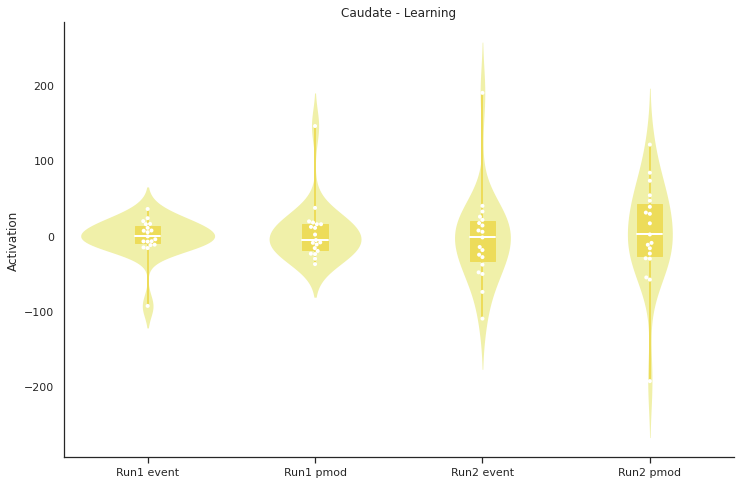

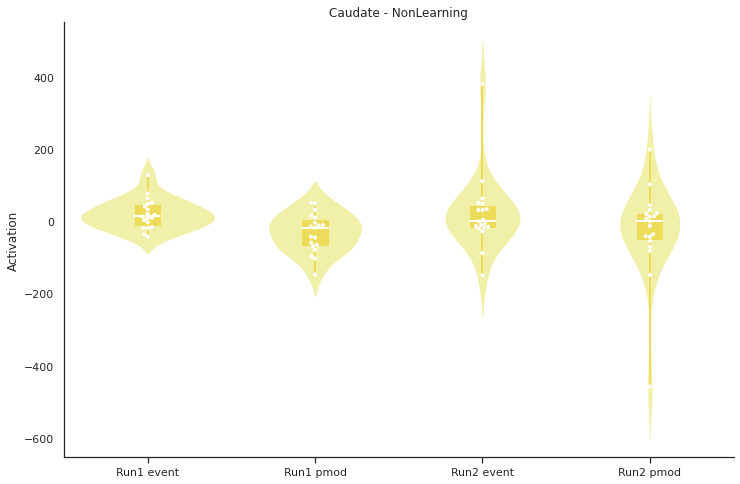

In [17]:
for d in ['early_learn_event', 'early_learn_pmod', 'late_learn_event', 'late_learn_pmod',
          'early_nonlearn_event', 'early_nonlearn_pmod', 'late_nonlearn_event', 'late_nonlearn_pmod']:
    print("Mean {0}: ".format(d), np.mean(caud_chart['{0}'.format(d)]))
    print("STD {0}: ".format(d), np.std(caud_chart['{0}'.format(d)]))
    print("Shapiro {0}".format(d), stats.shapiro(caud_chart['{0}'.format(d)])[1])
    print("")
    
for i in ['early_learn', 'late_learn', 'early_nonlearn', 'late_nonlearn']: 
    print("{0}: ".format(i))
    if stats.shapiro(caud_chart['{0}_event'.format(i)])[1] < 0.049 or stats.shapiro(caud_chart['{0}_pmod'.format(i)])[1] < 0.049:
        #add visual indicators if nonparametric test is significant
        if stats.wilcoxon(caud_chart['{0}_event'.format(i)], caud_chart['{0}_pmod'.format(i)])[:][-1] < 0.0124: #correction for multi comparisons
            print('Wilcoxon', stats.wilcoxon(caud_chart['{0}_event'.format(i)], caud_chart['{0}_pmod'.format(i)])[:], '<---- **')
        else:
            print('Wilcoxon', stats.wilcoxon(caud_chart['{0}_event'.format(i)], caud_chart['{0}_pmod'.format(i)])[:])
    else: #normal distributions
        if stats.ttest_rel(caud_chart['{0}_event'.format(i)], caud_chart['{0}_pmod'.format(i)])[:][-1] < 0.0124: #correction for multi comparisons
            print('t-test', stats.ttest_rel(caud_chart['{0}_event'.format(i)], caud_chart['{0}_pmod'.format(i)])[:], '<---- **')
        else:
            print('t-test', stats.ttest_rel(caud_chart['{0}_event'.format(i)], caud_chart['{0}_pmod'.format(i)])[:])   

    learning_d = ((np.average(caud_chart['{0}_event'.format(i)]) - np.average(caud_chart['{0}_pmod'.format(i)])) 
                / (sqrt((np.std(caud_chart['{0}_event'.format(i)],ddof=1))**2+np.std(caud_chart['{0}_pmod'.format(i)],ddof=1)**2)/2))
    print("Cohen's d = ", learning_d)
    print("")
    
#plot data using box and swarmplots
N = 4
conditions = ['Run1 event', 'Run1 pmod', 'Run2 event', 'Run2 pmod'] #labels

caud_allsubjs = [caud_chart['early_learn_event'], caud_chart['early_learn_pmod'],
                 caud_chart['late_learn_event'], caud_chart['late_learn_pmod'], 
                 caud_chart['early_nonlearn_event'], caud_chart['early_nonlearn_pmod'], 
                 caud_chart['late_nonlearn_event'], caud_chart['late_nonlearn_pmod']] #data to plot
ind = np.arange(N)
for i in range(2):
    fig, ax = plt.subplots(figsize = (12,8)) 
    sns.despine(top=True)
    if i == 0:
        sns.violinplot(data=caud_allsubjs[:4], color="#fcfc9d", inner=None, linewidth=0)
        ax.boxplot(caud_allsubjs[:4], whis='range', positions=ind, widths=0.15, patch_artist=True,
                   showcaps=False, boxprops=dict(color="#eddc5a", facecolor="#eddc5a"),
                   whiskerprops=dict(color="#eddc5a", linewidth=2, linestyle = "-"), 
                   medianprops=dict(color="w", linewidth=2))
        sns.swarmplot(data = caud_allsubjs[:4], size = 4, color = "white", edgecolor = "gray")
        ax.set_xticklabels(conditions) 
        ax.set_title("Caudate - Learning")         
    else:
        sns.violinplot(data=caud_allsubjs[4:], color="#fcfc9d", inner=None, linewidth=0)
        ax.boxplot(caud_allsubjs[4:], whis='range', positions=ind, widths=0.15, patch_artist=True,
                   showcaps=False, boxprops=dict(color="#eddc5a", facecolor="#eddc5a"),
                   whiskerprops=dict(color="#eddc5a", linewidth=2, linestyle = "-"), 
                   medianprops=dict(color="w", linewidth=2))
        sns.swarmplot(data = caud_allsubjs[4:], size = 4, color = "white", edgecolor = "gray") 
        ax.set_xticklabels(conditions)
        ax.set_title("Caudate - NonLearning") 
    ax.set_xticks(ind) 
    ax.xaxis.set_ticks_position('bottom')
    ax.set_ylabel("Activation") 
    #plt.savefig("/home/arenf001/figs/HPMA_C_caud{0}.png".format(i+1), dpi = 800)
plt.show() 

Mean early_event:  9.258842953431763
STD early_event:  27.145294053868916
Shapiro early_event 0.5361500382423401

Mean late_event:  9.321709031337186
STD late_event:  59.82898115340771
Shapiro late_event 0.0031137189362198114

Mean early_pmod:  -13.466118315528883
STD early_pmod:  35.93356079174326
Shapiro early_pmod 0.9920612573623657

Mean late_pmod:  -10.981635505333543
STD late_pmod:  73.19018259565905
Shapiro late_pmod 0.0031018340960144997

early: 
t-test (1.5393030933530656, 0.14112499557753783)
Cohen's d =  -0.982311492921584

late: 
Wilcoxon (92.0, 0.9217147827148438)
Cohen's d =  -0.41809783979738074



<ipython-input-26-8373a2e631a0>:39: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(caud_allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,


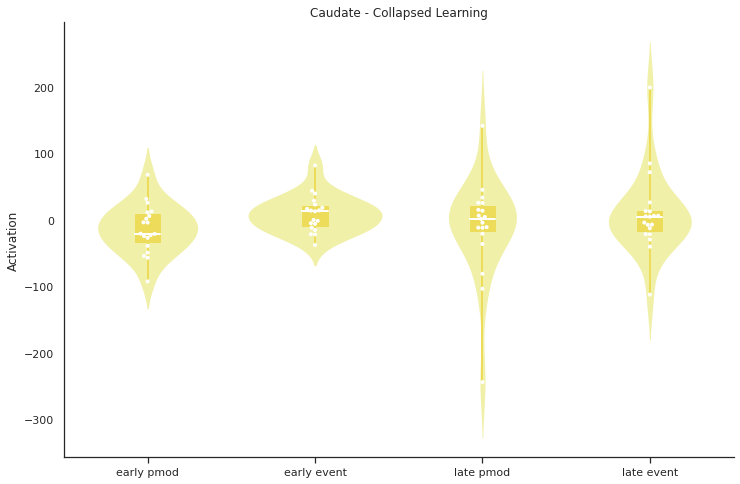

In [26]:
plot3 = {}
plot3['early_event'] = all_data_df[['caud_all_early_learn_event','caud_all_early_nonlearn_event']].mean(axis=1)
plot3['late_event'] = all_data_df[['caud_all_late_learn_event','caud_all_late_nonlearn_event']].mean(axis=1)
plot3['early_pmod'] = all_data_df[['caud_all_early_learn_pmod','caud_all_early_nonlearn_pmod']].mean(axis=1)
plot3['late_pmod'] = all_data_df[['caud_all_late_learn_pmod','caud_all_late_nonlearn_pmod']].mean(axis=1)
plot3_df = pd.DataFrame.from_dict(plot3)

for d in ['early_event', 'late_event', 'early_pmod', 'late_pmod']:
    print("Mean {0}: ".format(d), np.mean(plot3['{0}'.format(d)]))
    print("STD {0}: ".format(d), np.std(plot3['{0}'.format(d)]))
    print("Shapiro {0}".format(d), stats.shapiro(plot3['{0}'.format(d)])[1])
    print("")    
for i in ['early', 'late']:
    print("{0}: ".format(i))
    if stats.shapiro(plot3['{0}_event'.format(i)])[1] < 0.049 or stats.shapiro(plot3['{0}_pmod'.format(i)])[1] < 0.024:
        #add visual indicators if nonparametric test is significant
        if stats.wilcoxon(plot3['{0}_event'.format(i)], plot3['{0}_pmod'.format(i)])[:][-1] < 0.024: #correction for multi comparisons
            print('Wilcoxon', stats.wilcoxon(plot3['{0}_event'.format(i)], plot3['{0}_pmod'.format(i)])[:], '<---- **')
        else:
            print('Wilcoxon', stats.wilcoxon(plot3['{0}_event'.format(i)], plot3['{0}_pmod'.format(i)])[:])
    else: #normal distributions
        if stats.ttest_rel(plot3['{0}_event'.format(i)], plot3['{0}_pmod'.format(i)])[:][-1] < 0.024: #correction for multi comparisons
            print('t-test', stats.ttest_rel(plot3['{0}_event'.format(i)], plot3['{0}_pmod'.format(i)])[:], '<---- **')
        else:
            print('t-test', stats.ttest_rel(plot3['{0}_event'.format(i)], plot3['{0}_pmod'.format(i)])[:])   

    learning_d = ((np.average(plot3['{0}_pmod'.format(i)]) - np.average(plot3['{0}_event'.format(i)])) 
                / (sqrt((np.std(plot3['{0}_pmod'.format(i)],ddof=1))**2+np.std(plot3['{0}_event'.format(i)],ddof=1)**2)/2))
    print("Cohen's d = ", learning_d)
    print("")                      
N = 4
conditions = ['early pmod', 'early event', 'late pmod', 'late event']
caud_allsubjs = [plot3['early_pmod'], plot3['early_event'], plot3['late_pmod'], plot3['late_event']]
ind = np.arange(N)
width = 0.5
fig, ax = plt.subplots(figsize = (12,8))
sns.despine(top=True)
sns.violinplot(data=caud_allsubjs, color="#fcfc9d", inner=None, linewidth=0)
ax.boxplot(caud_allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,
           showcaps=False, boxprops=dict(color="#eddc5a", facecolor="#eddc5a"),
           whiskerprops=dict(color="#eddc5a", linewidth=2, linestyle = "-"), 
           medianprops=dict(color="w", linewidth=2))
sns.swarmplot(data = caud_allsubjs, size = 4, color = "white", edgecolor = "gray")
ax.set_xticklabels(conditions)
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel("Activation")
ax.set_title("Caudate - Collapsed Learning")
#plt.savefig("/home/arenf001/figs/HPMA_C_caud.png", dpi = 800)
plt.show()

In [19]:
plot3_df

,early_event,late_event,early_pmod,late_pmod
0,23.204638,-40.095312,-54.053686,45.450391
1,14.153188,85.133538,-26.920667,-80.938873
2,39.898063,71.932549,-49.201837,-103.503760
3,-4.849006,26.494262,6.048287,-36.073796
4,-21.439649,6.296205,25.977737,-4.060385
5,13.106872,-112.385738,-24.050665,141.781570
6,-5.873747,5.422266,1.834053,-11.632435
7,-11.568225,-3.885551,11.486614,4.627927
8,0.100748,-12.477426,-3.522164,15.255800
9,-15.127630,13.432273,12.944870,-20.667238


## Putamen

In [20]:
put_chart = {}
for x in ['early_learn_event', 'late_learn_event', 'early_nonlearn_event', 'late_nonlearn_event',
          'early_learn_pmod', 'late_learn_pmod', 'early_nonlearn_pmod', 'late_nonlearn_pmod']:
    put_chart['{0}'.format(x)] = all_data_df['put_all_{0}'.format(x)] 
put_chart_df = pd.DataFrame.from_dict(put_chart)

In [21]:
put_chart_df

,early_learn_event,late_learn_event,early_nonlearn_event,late_nonlearn_event,early_learn_pmod,late_learn_pmod,early_nonlearn_pmod,late_nonlearn_pmod
0,-8.198902,-17.265515,-10.821257,-25.045010,11.701840,16.752839,-6.843566,31.499915
1,-3.887757,314.511261,-3.774458,-18.571725,2.670680,-324.962936,-5.874338,27.067410
2,10.527065,34.876288,11.216614,103.871368,-13.128166,-51.101547,-22.831128,-126.921745
3,-8.744436,4.036702,-4.939399,22.469784,13.375533,-10.346143,2.511550,-31.223457
4,-9.273316,-54.779144,-35.807291,44.036476,12.251026,68.760550,43.873348,-55.426945
5,-6.719150,-26.841975,-0.723249,-101.942410,13.933245,29.682355,-1.734461,135.708893
6,2.372279,-48.533606,-4.823121,52.455269,-10.876780,68.592409,-1.735298,-71.372028
7,-24.634256,-11.033710,3.229394,-27.092312,39.207058,11.439467,-15.370307,50.951208
8,3.723595,-10.970231,-45.041223,-18.481409,-6.463676,15.102340,56.249279,28.127597
9,-20.499866,37.959354,-12.952713,3.511839,28.389439,-49.690313,12.965203,-9.027715


Mean early_learn_event:  -6.20733484468962
STD early_learn_event:  18.448233473398727
Shapiro early_learn_event 0.008837692439556122

Mean early_learn_pmod:  9.904725137509798
STD early_learn_pmod:  27.880477145006473
Shapiro early_learn_pmod 0.0056534092873334885

Mean late_learn_event:  5.333789566629811
STD late_learn_event:  78.40717742014678
Shapiro late_learn_event 4.204806828056462e-06

Mean late_learn_pmod:  -4.999034039284053
STD late_learn_pmod:  83.58938309496514
Shapiro late_learn_pmod 1.8493772586225532e-05

Mean early_nonlearn_event:  0.5914566909012041
STD early_nonlearn_event:  32.88812862408854
Shapiro early_nonlearn_event 0.009581103920936584

Mean early_nonlearn_pmod:  -4.71593482557096
STD early_nonlearn_pmod:  42.54421967183572
Shapiro early_nonlearn_pmod 0.2336936593055725

Mean late_nonlearn_event:  10.136336759517068
STD late_nonlearn_event:  57.39525019240225
Shapiro late_nonlearn_event 0.026979057118296623

Mean late_nonlearn_pmod:  -10.90479955861443
STD late

<ipython-input-22-f07ba37b0959>:41: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(put_allsubjs[:4], whis='range', positions=ind, widths=0.15, patch_artist=True,
<ipython-input-22-f07ba37b0959>:50: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(put_allsubjs[4:], whis='range', positions=ind, widths=0.15, patch_artist=True,


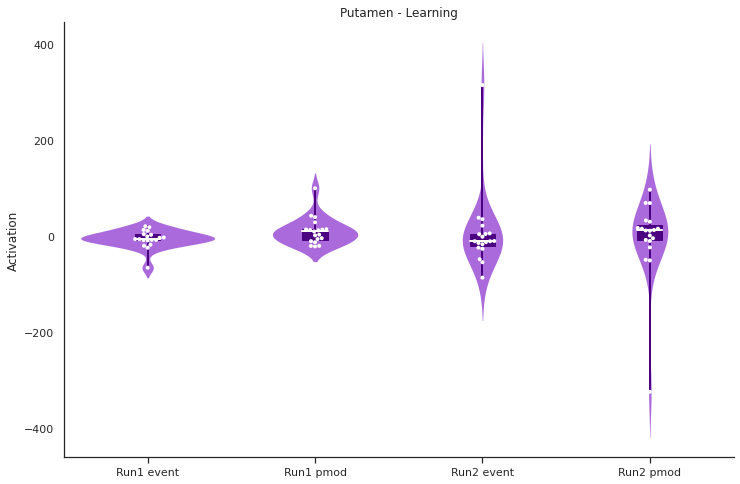

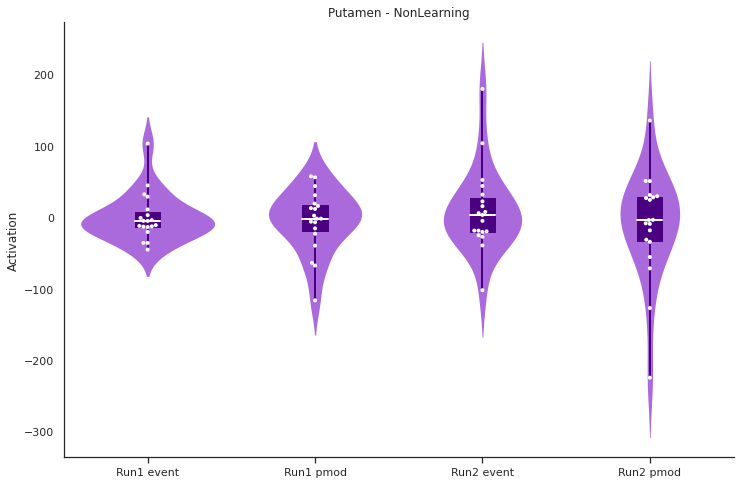

In [22]:
for d in ['early_learn_event', 'early_learn_pmod', 'late_learn_event', 'late_learn_pmod',
          'early_nonlearn_event', 'early_nonlearn_pmod', 'late_nonlearn_event', 'late_nonlearn_pmod']:
    print("Mean {0}: ".format(d), np.mean(put_chart['{0}'.format(d)]))
    print("STD {0}: ".format(d), np.std(put_chart['{0}'.format(d)]))
    print("Shapiro {0}".format(d), stats.shapiro(put_chart['{0}'.format(d)])[1])
    print("")
    
for i in ['early_learn', 'late_learn', 'early_nonlearn', 'late_nonlearn']: 
    print("{0}: ".format(i))
    if stats.shapiro(put_chart['{0}_event'.format(i)])[1] < 0.049 or stats.shapiro(put_chart['{0}_pmod'.format(i)])[1] < 0.049:
        #add visual indicators if nonparametric test is significant
        if stats.wilcoxon(put_chart['{0}_event'.format(i)], put_chart['{0}_pmod'.format(i)])[:][-1] < 0.0124: #correction for multi comparisons
            print('Wilcoxon', stats.wilcoxon(put_chart['{0}_event'.format(i)], put_chart['{0}_pmod'.format(i)])[:], '<---- **')
        else:
            print('Wilcoxon', stats.wilcoxon(put_chart['{0}_event'.format(i)], put_chart['{0}_pmod'.format(i)])[:])
    else: #normal distributions
        if stats.ttest_rel(put_chart['{0}_event'.format(i)], put_chart['{0}_pmod'.format(i)])[:][-1] < 0.0124: #correction for multi comparisons
            print('t-test', stats.ttest_rel(put_chart['{0}_event'.format(i)], put_chart['{0}_pmod'.format(i)])[:], '<---- **')
        else:
            print('t-test', stats.ttest_rel(put_chart['{0}_event'.format(i)], put_chart['{0}_pmod'.format(i)])[:])   

    learning_d = ((np.average(put_chart['{0}_event'.format(i)]) - np.average(put_chart['{0}_pmod'.format(i)])) 
                / (sqrt((np.std(put_chart['{0}_event'.format(i)],ddof=1))**2+np.std(put_chart['{0}_pmod'.format(i)],ddof=1)**2)/2))
    print("Cohen's d = ", learning_d)
    print("")
    
#plot data using box and swarmplots
N = 4
conditions = ['Run1 event', 'Run1 pmod', 'Run2 event', 'Run2 pmod'] #labels
put_allsubjs = [put_chart['early_learn_event'], put_chart['early_learn_pmod'],
                put_chart['late_learn_event'], put_chart['late_learn_pmod'], 
                put_chart['early_nonlearn_event'], put_chart['early_nonlearn_pmod'], 
                put_chart['late_nonlearn_event'], put_chart['late_nonlearn_pmod']] #data to plot

ind = np.arange(N)
for i in range(2):
    fig, ax = plt.subplots(figsize = (12,8)) 
    sns.despine(top=True)
    if i == 0:
        sns.violinplot(data=put_allsubjs[:4], color="#af52f4", inner=None, linewidth=0, saturation=0.7)
        ax.boxplot(put_allsubjs[:4], whis='range', positions=ind, widths=0.15, patch_artist=True,
                   showcaps=False, boxprops=dict(color="indigo", facecolor="indigo"),
                   whiskerprops=dict(color="indigo", linewidth=2, linestyle = "-"),
                   medianprops=dict(color="w", linewidth=2))
        sns.swarmplot(data = put_allsubjs[:4], size = 4, color = "white", edgecolor = "gray")           
        ax.set_xticklabels(conditions) 
        ax.set_title("Putamen - Learning")         
    else:
        sns.violinplot(data=put_allsubjs[4:], color="#af52f4", inner=None, linewidth=0, saturation=0.7)
        ax.boxplot(put_allsubjs[4:], whis='range', positions=ind, widths=0.15, patch_artist=True,
                   showcaps=False, boxprops=dict(color="indigo", facecolor="indigo"),
                   whiskerprops=dict(color="indigo", linewidth=2, linestyle = "-"),
                   medianprops=dict(color="w", linewidth=2))
        sns.swarmplot(data = put_allsubjs[4:], size = 4, color = "white", edgecolor = "gray")           
        ax.set_xticklabels(conditions)
        ax.set_title("Putamen - NonLearning") 
    ax.set_xticks(ind)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_ylabel("Activation") 
    #plt.savefig("/home/arenf001/figs/HPMA_C_put{0}.png".format(i+1), dpi = 800)
plt.show() 

early_event Mean:  -2.807939076894208
early_event STD:  21.49697849440756
Shapiro early_event 0.06936284154653549

late_event Mean:  7.735063163073439
late_event STD:  46.277721621509734
Shapiro late_event 0.003845458384603262

early_pmod Mean:  2.594395155969419
early_pmod STD:  28.724128605660994
Shapiro early_pmod 0.22182826697826385

late_pmod Mean:  -7.951916798949242
late_pmod STD:  53.34551332523209
Shapiro late_pmod 0.016898028552532196

early: 
t-test (-0.4584154394046358, 0.6521403599139333)
Cohen's d =  0.29312213549847804

late: 
Wilcoxon (90.0, 0.8595733642578125)
Cohen's d =  -0.43240722132734316



<ipython-input-27-c6908a402731>:40: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(put_allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,


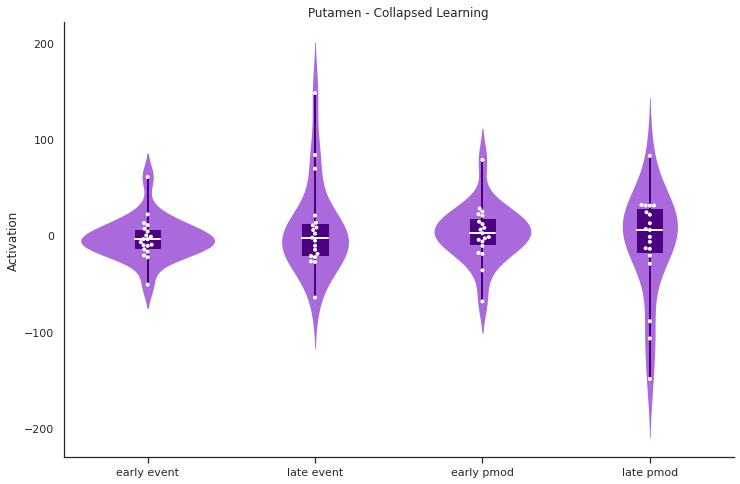

In [27]:
plot4 = {}
plot4['early_event'] = all_data_df[['put_all_early_learn_event','put_all_early_nonlearn_event']].mean(axis=1)
plot4['late_event'] = all_data_df[['put_all_late_learn_event','put_all_late_nonlearn_event']].mean(axis=1)
plot4['early_pmod'] = all_data_df[['put_all_early_learn_pmod','put_all_early_nonlearn_pmod']].mean(axis=1)
plot4['late_pmod'] = all_data_df[['put_all_late_learn_pmod','put_all_late_nonlearn_pmod']].mean(axis=1)
plot4_df = pd.DataFrame.from_dict(plot4)

for d in ['early_event', 'late_event', 'early_pmod', 'late_pmod']:
    print("{0} Mean: ".format(d), np.mean(plot4['{0}'.format(d)]))
    print("{0} STD: ".format(d), np.std(plot4['{0}'.format(d)]))
    print("Shapiro {0}".format(d), stats.shapiro(plot4['{0}'.format(d)])[1])
    print("")    
for i in ['early', 'late']:
    print("{0}: ".format(i))
    if stats.shapiro(plot4['{0}_event'.format(i)])[1] < 0.049 or stats.shapiro(plot4['{0}_pmod'.format(i)])[1] < 0.024:
        #add visual indicators if nonparametric test is significant
        if stats.wilcoxon(plot4['{0}_event'.format(i)], plot4['{0}_pmod'.format(i)])[:][-1] < 0.024: #correction for multi comparisons
            print('Wilcoxon', stats.wilcoxon(plot4['{0}_event'.format(i)], plot4['{0}_pmod'.format(i)])[:], '<---- **')
        else:
            print('Wilcoxon', stats.wilcoxon(plot4['{0}_event'.format(i)], plot4['{0}_pmod'.format(i)])[:])
    else: #normal distributions
        if stats.ttest_rel(plot4['{0}_event'.format(i)], plot4['{0}_pmod'.format(i)])[:][-1] < 0.024: #correction for multi comparisons
            print('t-test', stats.ttest_rel(plot4['{0}_event'.format(i)], plot4['{0}_pmod'.format(i)])[:], '<---- **')
        else:
            print('t-test', stats.ttest_rel(plot4['{0}_event'.format(i)], plot4['{0}_pmod'.format(i)])[:])   

    learning_d = ((np.average(plot4['{0}_pmod'.format(i)]) - np.average(plot4['{0}_event'.format(i)])) 
                / (sqrt((np.std(plot4['{0}_pmod'.format(i)],ddof=1))**2+np.std(plot4['{0}_event'.format(i)],ddof=1)**2)/2))
    print("Cohen's d = ", learning_d)
    print("")                            
N = 4
conditions = ['early event', 'late event', 'early pmod', 'late pmod']
put_allsubjs = [plot4['early_event'], plot4['late_event'], 
                plot4['early_pmod'], plot4['late_pmod']]
ind = np.arange(N)
width = 0.5
fig, ax = plt.subplots(figsize = (12,8))
sns.despine(top=True)
sns.violinplot(data=put_allsubjs, color="#af52f4", inner=None, linewidth=0, saturation=0.7)
ax.boxplot(put_allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,
           showcaps=False, boxprops=dict(color="indigo", facecolor="indigo"),
           whiskerprops=dict(color="indigo", linewidth=2, linestyle = "-"),
           medianprops=dict(color="w", linewidth=2))
sns.swarmplot(data = put_allsubjs, size = 4, color = "white", edgecolor = "gray")           
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel("Activation")
ax.set_title("Putamen - Collapsed Learning")
#plt.savefig("/home/arenf001/figs/HPMA_C_put.png", dpi = 800)
plt.show()